In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
sns.set_context("paper")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_acc(y_true, y_pred):
    total = y_true.size(0)
    correct = (y_pred == y_true).sum().item()
    return correct / total

def get_acc_at_k(y_true, y_pred, k=2):
    y_true = torch.tensor(y_true) if type(y_true) != torch.Tensor else y_true
    y_pred = torch.tensor(y_pred) if type(y_pred) != torch.Tensor else y_pred
    total = len(y_true)
    y_weights, y_idx = torch.topk(y_true, k=k, dim=-1)
    out_weights, out_idx = torch.topk(y_pred, k=k, dim=-1)
    correct = torch.sum(torch.eq(y_idx, out_idx) * y_weights)
    acc = correct / total
    return acc.item()

In [3]:
def show_values_on_bars(axs, values, y_height_addon=0):
    def _show_on_single_plot(ax):        
        for p, v in zip(ax.patches, values):
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + y_height_addon
            if type(v) != str:
                value = ("+" if v > 0 else "") + '{:.0f}%'.format(v)
            else:
                value = v
            ax.text(_x, _y, value, ha="center", size='small') 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Images

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

from RandAugment import RandAugment
from transformations.image.mixtures import mixup2, cutmix2, tile

import matplotlib.pyplot as plt

In [7]:
def get_logits(model, X, batch_size=8):
    model.eval()
    out = []
    for pos in range(0, len(X), batch_size):
        X_ = X[pos:pos + batch_size] 
        logits = model(X_)
        out.append(logits)
    return torch.cat(out).cpu()

In [8]:
def get_dataloader(config):

    test_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    if config['use_basicaug']:
        test_transform.transforms.insert(0, transforms.RandomHorizontalFlip())
        test_transform.transforms.insert(0, transforms.RandomCrop(32, padding=4))

    if config['use_randaug']:
        n = config['randaug_n']
        m = config['randaug_m']
        test_transform.transforms.insert(0, RandAugment(n=2, m=3))

    if config['dataset'] == 'CIFAR10':
        dataset_dir = 'C:/data/CIFAR10'
        _MEAN, _STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        test_transform.transforms.insert(
            len(test_transform.transforms), transforms.Normalize(_MEAN, _STD))
        test_dataset = torchvision.datasets.CIFAR10(
            dataset_dir, train=False, transform=test_transform, download=True)
    elif config['dataset'] == 'MNIST':
        dataset_dir = 'C:/data/MNIST'
        _MEAN, _STD = (0.1307,), (0.3081,)
        test_transform.transforms.insert(
            len(test_transform.transforms), transforms.Normalize(_MEAN, _STD))
        test_dataset = torchvision.datasets.MNIST(
            dataset_dir, train=False, transform=test_transform, download=True)
    else:
        raise InputError("dataset not supported...")

    collator = torch.utils.data.dataloader.default_collate
    
    if config['use_mixup2']:
        collator = mixup2.Mixup2Collator(
            alpha=config['alpha'],  
            target_pairs=config['target_pairs'], 
            target_prob=config['target_prob'], 
            num_classes=config['n_classes']
        )
    if config['use_cutmix2']:
        collator = cutmix2.CutMix2Collator(
            alpha=config['alpha'],  
            target_pairs=config['target_pairs'], 
            target_prob=config['target_prob'], 
            resize_prob=config['resize_prob'], 
            num_classes=config['n_classes']
        )
    if config['use_tile']:
        collator = tile.TileCollator(
            num_tiles=config['num_tiles'],  
            target_pairs=config['target_pairs'], 
            target_prob=config['target_prob'], 
            num_classes=config['n_classes']
        )
                
    dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        collate_fn=collator,
        shuffle=True,
        pin_memory=True,
        drop_last=False,
    )
    return dataloader

In [9]:
# print(torch.hub.list("chenyaofo/pytorch-cifar-models", force_reload=True))

In [10]:
num_suites = 100
num_tests = 100

datasets = ["CIFAR10"]
tranforms = ['Cutmix'] # ['ORIG', 'INV', 'Mixup2', 'Cutmix', 'Cutmix2', 'Tile']
MODEL_NAMES = [ 
    'cifar10_shufflenetv2_x2_0',
    'cifar10_resnet56',
    'cifar10_mobilenetv2_x1_0',
]

results = []
for MODEL_NAME in MODEL_NAMES:
    
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", MODEL_NAME, pretrained=True).to(device)
    model.eval()
    
    for d in datasets:
                        
        for t in tranforms:
            
            config = {
                'dataset': d,
                'batch_size': num_tests,
                'num_workers': 2,
                'use_basicaug': t == 'INV' and d == 'MNIST',
                'use_randaug': t == 'INV' and d != 'MNIST',
                'use_mixup2': t == 'Mixup2',
                'use_cutmix2': 'Cutmix' in t,
                'use_tile': t == 'Tile',
                'randaug_n': 2,
                'randaug_m': 3,
                'alpha': 1.0,
                'target_pairs': [],
                'target_prob': 1.0,
                'resize_prob': 1.0 if t == 'Cutmix2' else 0,
                'n_classes': 10,
                'num_tiles': 4,
            }
            
            dataloader = get_dataloader(config)
            is_soft_label = False
            if t not in ['ORIG', 'INV']:
                is_soft_label = True
            
            accs = []
            for _ in tqdm(range(num_suites)):

                    X, y_true = next(iter(dataloader))

                    logits = get_logits(model, X.to(device), batch_size=8)
                    
                    if is_soft_label:
                        acc = get_acc_at_k(y_true, logits, k=2)
                    else:
                        soft_m = torch.softmax(logits, dim=1)
                        y_pred = torch.argmax(soft_m, dim=1)
                        acc = get_acc(y_true, y_pred)
                        
                    # print(acc)

                    accs.append(acc)

            test_acc = sum(accs) / len(accs)

            out = {
                "MODEL_NAME": MODEL_NAME,
                "dataset": d,
                'trans': t,
                "test_acc": test_acc
            }

            print(out)
            results.append(out)
        
df = pd.DataFrame(results)

Using cache found in C:\Users\Fabrice/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified



{'MODEL_NAME': 'cifar10_shufflenetv2_x2_0', 'dataset': 'CIFAR10', 'trans': 'Cutmix', 'test_acc': 0.5339350276440382}


Using cache found in C:\Users\Fabrice/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified



{'MODEL_NAME': 'cifar10_resnet56', 'dataset': 'CIFAR10', 'trans': 'Cutmix', 'test_acc': 0.5414444274455309}


Using cache found in C:\Users\Fabrice/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified



{'MODEL_NAME': 'cifar10_mobilenetv2_x1_0', 'dataset': 'CIFAR10', 'trans': 'Cutmix', 'test_acc': 0.5272044353187084}


In [11]:
df

,MODEL_NAME,dataset,trans,test_acc
0,cifar10_shufflenetv2_x2_0,CIFAR10,Cutmix,0.533935
1,cifar10_resnet56,CIFAR10,Cutmix,0.541444
2,cifar10_mobilenetv2_x1_0,CIFAR10,Cutmix,0.527204


In [12]:
df.to_clipboard(excel=True)

In [11]:
df.to_csv('test_models_cifar10_results.csv')

0.94375


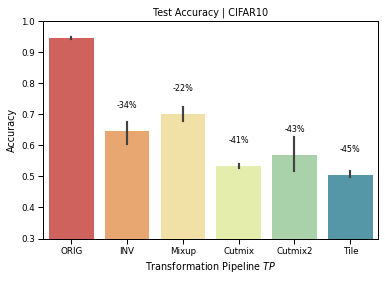

In [4]:
for d in ['CIFAR10']: 
    
    df = pd.read_csv('test_models_cifar10_results.csv')
    
    ds = (df['dataset']==d)
    
    df = df[ds]
    
    ORIG_acc = df[(df['trans']=='ORIG')]['test_acc'].iloc[0]
    print(ORIG_acc)
    df['improv'] = (df['test_acc'] - ORIG_acc) * 100
    
    g = sns.barplot(data=df[df.dataset.str.contains(d)], x='trans', y='test_acc', palette='Spectral')
    g.set_xlabel('Transformation Pipeline $TP$')
    g.set_ylabel('Accuracy')
    g.set_ylim((0.3, 1.00))
    # g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title('Test Accuracy | ' +  d)
    values = df.improv.tolist()
    values[0] = ""
    show_values_on_bars(g, values, 0.075)
    g.figure.savefig('imgs/test_acc_' + d)
    plt.show()

# Text

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils import *

In [52]:
class CustomModelWrapper:
    def __init__(self, model, tokenizer, batch_size=4):
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(self.model.parameters()).device
        self.batch_size = batch_size

    def __call__(self, text_input_list):
        out = []
        i = 0
        while i < len(text_input_list):
            batch = text_input_list[i : i + self.batch_size]
            encoding = self.tokenizer(batch, padding=True, truncation=True, max_length=250, return_tensors='pt')
            outputs = self.model(encoding['input_ids'].to(self.device), attention_mask=encoding['attention_mask'].to(self.device))
            # preds = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu()
            out.append(outputs.logits.detach().cpu())
            i += self.batch_size
        out = torch.cat(out)
        return out

In [5]:
num_suites = 100
num_tests = 100

datasets = [('AG_NEWS', 'ag-news'), ('SST2', 'SST-2')]
tranforms = ['ORIG', 'INV', 'SIB', 'INVSIB', 'TextMix', 'SentMix', 'WordMix']
MODEL_NAMES = [
    "textattack/bert-base-uncased-SST-2",
    "textattack/roberta-base-SST-2",
    "textattack/bert-base-uncased-ag-news",
    "textattack/roberta-base-ag-news",
]

results = []
for MODEL_NAME in MODEL_NAMES:
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)

    mw = CustomModelWrapper(model, tokenizer)
    
    for d, d_ in datasets:
        
        if d_ not in MODEL_NAME:
            continue
        
        for t in tranforms:
            
            text = npy_load("./assets/" + d + "/" + t + "/text.npy")
            label = npy_load("./assets/" + d + "/" + t + "/label.npy")
            is_soft_label = False
            if len(label.shape) > 1:
                is_soft_label = True
                                
            # print("MODEL_NAME: {}, dataset: {}-{}, is_soft_label: {}".format(MODEL_NAME, d, t, is_soft_label))
            
            accs = []
            for i in range(num_suites):
                
                idx = np.random.choice(np.arange(len(text)), num_tests, replace=False)
                text_sample = text[idx]
                label_sample = label[idx]
                               
                logits = mw([str(x) for x in text_sample])
                y_true = torch.tensor(label_sample)
                
                if is_soft_label:
                    acc = get_acc_at_k(y_true, logits, k=2)
                else:
                    soft_m = torch.softmax(logits, dim=1)
                    y_pred = torch.argmax(soft_m, dim=1)
                    acc = get_acc(y_true, y_pred)
                    
                accs.append(acc)
                
            test_acc = sum(accs) / len(accs)
                
            out = {
                "MODEL_NAME": MODEL_NAME,
                "dataset": d + "-" + t,
                "test_acc": test_acc
            }
            
            print(out)
            results.append(out)
            
df = pd.DataFrame(results)

MODEL_NAME: textattack/bert-base-uncased-SST-2, dataset: SST2-ORIG, is_soft_label: False
{'MODEL_NAME': 'textattack/bert-base-uncased-SST-2', 'dataset': 'SST2-ORIG', 'test_acc': 0.9871999999999994}
MODEL_NAME: textattack/bert-base-uncased-SST-2, dataset: SST2-INV, is_soft_label: False
{'MODEL_NAME': 'textattack/bert-base-uncased-SST-2', 'dataset': 'SST2-INV', 'test_acc': 0.7443000000000005}
MODEL_NAME: textattack/bert-base-uncased-SST-2, dataset: SST2-SIB, is_soft_label: True
{'MODEL_NAME': 'textattack/bert-base-uncased-SST-2', 'dataset': 'SST2-SIB', 'test_acc': 0.7052740745272483}
MODEL_NAME: textattack/bert-base-uncased-SST-2, dataset: SST2-INVSIB, is_soft_label: True
{'MODEL_NAME': 'textattack/bert-base-uncased-SST-2', 'dataset': 'SST2-INVSIB', 'test_acc': 0.7184545924036227}
MODEL_NAME: textattack/bert-base-uncased-SST-2, dataset: SST2-TextMix, is_soft_label: True
{'MODEL_NAME': 'textattack/bert-base-uncased-SST-2', 'dataset': 'SST2-TextMix', 'test_acc': 0.8232}
MODEL_NAME: textatt

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MODEL_NAME: textattack/roberta-base-SST-2, dataset: SST2-ORIG, is_soft_label: False
{'MODEL_NAME': 'textattack/roberta-base-SST-2', 'dataset': 'SST2-ORIG', 'test_acc': 0.9625999999999998}
MODEL_NAME: textattack/roberta-base-SST-2, dataset: SST2-INV, is_soft_label: False
{'MODEL_NAME': 'textattack/roberta-base-SST-2', 'dataset': 'SST2-INV', 'test_acc': 0.7603}
MODEL_NAME: textattack/roberta-base-SST-2, dataset: SST2-SIB, is_soft_label: True
{'MODEL_NAME': 'textattack/roberta-base-SST-2', 'dataset': 'SST2-SIB', 'test_acc': 0.6835538111180094}
MODEL_NAME: textattack/roberta-base-SST-2, dataset: SST2-INVSIB, is_soft_label: True
{'MODEL_NAME': 'textattack/roberta-base-SST-2', 'dataset': 'SST2-INVSIB', 'test_acc': 0.7172590575584402}
MODEL_NAME: textattack/roberta-base-SST-2, dataset: SST2-TextMix, is_soft_label: True
{'MODEL_NAME': 'textattack/roberta-base-SST-2', 'dataset': 'SST2-TextMix', 'test_acc': 0.8348000000000002}
MODEL_NAME: textattack/roberta-base-SST-2, dataset: SST2-SentMix, is_

Some weights of the model checkpoint at textattack/roberta-base-ag-news were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MODEL_NAME: textattack/roberta-base-ag-news, dataset: AG_NEWS-ORIG, is_soft_label: False
{'MODEL_NAME': 'textattack/roberta-base-ag-news', 'dataset': 'AG_NEWS-ORIG', 'test_acc': 0.985799999999999}
MODEL_NAME: textattack/roberta-base-ag-news, dataset: AG_NEWS-INV, is_soft_label: False
{'MODEL_NAME': 'textattack/roberta-base-ag-news', 'dataset': 'AG_NEWS-INV', 'test_acc': 0.8363999999999998}
MODEL_NAME: textattack/roberta-base-ag-news, dataset: AG_NEWS-SIB, is_soft_label: True
{'MODEL_NAME': 'textattack/roberta-base-ag-news', 'dataset': 'AG_NEWS-SIB', 'test_acc': 0.6100767345357251}
MODEL_NAME: textattack/roberta-base-ag-news, dataset: AG_NEWS-INVSIB, is_soft_label: True
{'MODEL_NAME': 'textattack/roberta-base-ag-news', 'dataset': 'AG_NEWS-INVSIB', 'test_acc': 0.6975635848964127}
MODEL_NAME: textattack/roberta-base-ag-news, dataset: AG_NEWS-TextMix, is_soft_label: True
{'MODEL_NAME': 'textattack/roberta-base-ag-news', 'dataset': 'AG_NEWS-TextMix', 'test_acc': 0.6133232601808546}
MODEL_NA

In [6]:
df

,MODEL_NAME,dataset,test_acc
0,textattack/bert-base-uncased-SST-2,SST2-ORIG,0.987200
1,textattack/bert-base-uncased-SST-2,SST2-INV,0.744300
2,textattack/bert-base-uncased-SST-2,SST2-SIB,0.705274
3,textattack/bert-base-uncased-SST-2,SST2-INVSIB,0.718455
4,textattack/bert-base-uncased-SST-2,SST2-TextMix,0.823200
5,textattack/bert-base-uncased-SST-2,SST2-SentMix,0.813400
6,textattack/bert-base-uncased-SST-2,SST2-WordMix,0.741200
7,textattack/roberta-base-SST-2,SST2-ORIG,0.962600
8,textattack/roberta-base-SST-2,SST2-INV,0.760300
9,textattack/roberta-base-SST-2,SST2-SIB,0.683554


In [7]:
df.to_csv('test_models_results.csv')

In [ ]:
for m in ['BERT', 'RoBERTa']:

    for d in ['SST2', 'AG_NEWS']: 

        df = pd.read_csv('test_models_results.csv')

        df['trans'] = df['dataset'].str.split("-").map(lambda x: x[-1])
        df['dataset'] = df['dataset'].str.split("-").map(lambda x: x[0])

        ds = (df['dataset']==d)
        ms = (df['MODEL_NAME'].str.contains(m.lower()+'-'))

        df = df[ds & ms]

        ORIG_acc = df[(df['trans']=='ORIG')]['test_acc'].iloc[0]
        print(ORIG_acc)
        df['improv'] = df['test_acc'] - ORIG_acc

        g = sns.barplot(data=df[df.dataset.str.contains(d)], x='trans', y='test_acc', palette='Spectral')
        g.set_xlabel('Transformation Pipeline $TP$')
        g.set_ylabel('Accuracy')
        g.set_ylim((0.3, 1.05))
        g.set_title('Test Accuracy for ' +  d + ' | ' + m)
        values = df.improv.tolist()
        values[0] = ""
        show_values_on_bars(g, values)
        g.figure.savefig('imgs/test_acc_' + d)
        plt.show()

In [1]:
import seaborn as sns

In [2]:
sns.set_context("paper")

In [55]:
df

,Unnamed: 0,MODEL_NAME,dataset,tran,test_acc,tester_type,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,improv
14,14,textattack/bert-base-uncased-ag-news,AG_NEWS,ORIG,1.00,model,NaN,NaN,NaN,NaN,0.0
15,15,textattack/bert-base-uncased-ag-news,AG_NEWS,INV,0.87,model,NaN,NaN,NaN,NaN,-13.0
16,16,textattack/bert-base-uncased-ag-news,AG_NEWS,SIB,0.63,model,NaN,NaN,NaN,NaN,-37.0
17,17,textattack/bert-base-uncased-ag-news,AG_NEWS,INVSIB,0.75,model,NaN,NaN,NaN,NaN,-25.0
18,18,textattack/bert-base-uncased-ag-news,AG_NEWS,TextMix,0.64,model,NaN,NaN,NaN,NaN,-36.0
19,19,textattack/bert-base-uncased-ag-news,AG_NEWS,SentMix,0.48,model,NaN,NaN,NaN,NaN,-52.0
20,20,textattack/bert-base-uncased-ag-news,AG_NEWS,WordMix,0.60,model,NaN,NaN,NaN,NaN,-40.0
21,21,textattack/roberta-base-ag-news,AG_NEWS,ORIG,0.99,model,NaN,NaN,NaN,NaN,-1.0
22,22,textattack/roberta-base-ag-news,AG_NEWS,INV,0.84,model,NaN,NaN,NaN,NaN,-16.0
23,23,textattack/roberta-base-ag-news,AG_NEWS,SIB,0.61,model,NaN,NaN,NaN,NaN,-39.0


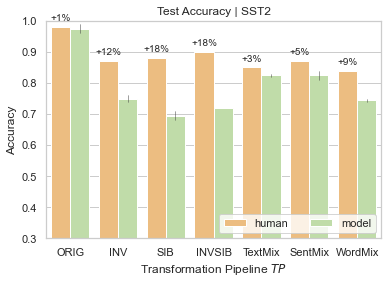

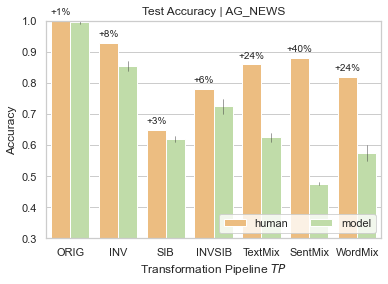

In [119]:
for d in ['SST2', 'AG_NEWS']: 
    
    df = pd.read_csv('test_models_results.csv')
    
    ds = (df['dataset']==d)
    
    df = df[ds]
    
    hum_avg = df[(df['tester_type']=='human')]['test_acc'].to_numpy()
    df_ = df[(df['tester_type']=='model')].groupby(['tran'], as_index=False).mean()
    df_ = df_.merge(df[['id',  'tran']], on='tran').sort_values('id_y')
    df_ = df_[['test_acc', 'tran']].drop_duplicates()
    mod_avg = df_['test_acc'].to_numpy()
    diff = (hum_avg - mod_avg) * 100
    
    g = sns.barplot(data=df[df.dataset.str.contains(d)], x='tran', y='test_acc', hue='tester_type', palette='Spectral', errwidth=0.5)
    g.set_xlabel('Transformation Pipeline $TP$')
    g.set_ylabel('Accuracy')
    g.set_ylim((0.3, 1.00))
    # g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title('Test Accuracy | ' +  d)
    g.legend(ncol=2, loc="lower right", frameon=True)
    values = diff.tolist()
    values = ['{:+.0f}%'.format(v) for v in values]
    show_values_on_bars(g, values, 0.02)
    g.figure.savefig('imgs/test_acc_' + d + '_vhuman')
    plt.show()